In [1]:
import os
import sys
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import urllib
from tensorflow.python.framework import ops
ops.reset_default_graph()

/Users/takahashikoji/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sess = tf.Session()

### __モデルパラメータ設定__

In [3]:
batch_size = 128
data_dir = 'temp'
output_every = 50
generations = 20000
eval_every = 500
image_height = 32
image_width = 32
crop_height = 24
crop_width = 24
num_channels = 3
num_targets = 10
extract_folder = 'cifar-10-batches-bin'

### __モデルをトレーニングしながら学習率を引き下げていく事が推奨される。そこで学習率を幾何級数的に減衰させる。__

In [4]:
# 学習率を幾何級数的に減衰させるためのパラメータ   
learning_rate = 0.1
lr_decay = 0.1
num_gens_to_wait = 250.        #  floatにしないと後でエラーが出るので注意！！

### tar.gz CIFAR-10をバイナリデータとして読み込み、'temp'ディレクトリ内で解凍する。

In [5]:
# バイナリデータとしてCIFAR-10を読み込むためのパラメータを設定する
image_vec_length = image_height * image_width * num_channels     # 3072
record_length = 1 + image_vec_length  # 3073 1はラベル（０〜９）の分

In [8]:
# os.path.join() でtemp/cifar-10-binary.tar.gz に
data_file = os.path.join(data_dir, 'cifar-10-binary.tar.gz')
print(data_file)

temp/cifar-10-binary.tar.gz


In [13]:
cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'

In [14]:
# urllib.request.urlretrieve() urlからリソースを取得して１時的に格納　
filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file)

In [17]:
# tarfile　を'temp' ディレクトリで解凍
tarfile.open(filepath , 'r:gz').extractall(data_dir)

### レコードリーダーを設定し、ランダムに変形された画像を返すための read_cifar_files関数を定義

In [18]:
# queue = 列　 filename_queue の中身 'data_batch_[1~5].bin' 'test_batch.bin' ファイルが入っている

def read_cifar_files(filename_queue, distort_images = True):
    # tf.FixedLengthrecordReader(record_bytes=int) ファイルから固定長レコードを出力するリーダー。
    reader = tf.FixedLengthRecordReader(record_bytes=record_length)
    key, record_string = reader.read(filename_queue)
    # tf.decode_raw() 文字列のバイトを数字のベクトル(tf.uint8)として再解釈する　
    record_bytes = tf.decode_raw(record_string, tf.uint8)
    
    # ラベル(正解データ)を抽出する  tf.cast()テンソルを新しい形に変形する。
    # tf.slice() テンソルからスライスを抽出する 先頭１バイトを抽出
    image_label = tf.cast(tf.slice(record_bytes, [0], [1]), tf.int32)
  
    # 画像を２バイト目から抽出する
    image_extracted = tf.reshape(tf.slice(record_bytes, [1], [image_vec_length]),
                                 [num_channels, image_height, image_width])
    
    # 画像を変形 tf.transpose() 転置メソッド perm=[1,2,0]  bitmap形式に変換
    # きっとimage_uint8image はこういう形状になっていると思われる (32,32,3)
    image_uint8image = tf.transpose(image_extracted, [1, 2, 0])
    # tf.cast() でfloat型に変換している
    reshaped_image = tf.cast(image_uint8image, tf.float32)
    # 画像をランダムに切り取る イメージをターゲットの幅と高さに切り取り、またはパディングします。
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image, crop_width, crop_height)
    
    if distort_images:
        # 画像の左右を反転させ、明るさとコントラストを変更
        # tf.image.random_flip_left_right() 画像を左右にランダムに反転します（左から右）
        final_image = tf.image.random_flip_left_right(final_image)
        # tf.image.random_brightness() ランダムな係数で画像の明るさを調整します
        final_image = tf.image.random_brightness(final_image,max_delta=63)
        # 画像のコントラストをランダムなファクタで調整します。
        final_image = tf.image.random_contrast(final_image,lower=0.2, upper=1.8)

    # 画像を正規化 tf.image.per_image_standardization()
    final_image = tf.image.per_image_standardization(final_image)
    return(final_image, image_label)


### 画像パイプライン処理にデータを流し込む input_pipeline関数を定義

In [19]:
# バッチプロセッサで使用するために画像パイプライン処理にデータを流し込む関数を定義する
# batch_size = 128
# extract_folder = 'cifar-10-batches-bin'
def input_pipeline(batch_size, train_logical=True):
    if train_logical:
        # os.path.join で 'temp','cifar-10-batches-bin','data_batch_1~5.bin' のパスを結合
        files = [os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(i)) for i in range(1,6)]
    else:
        # 'temp','cifar-10-batches-bin','test_batch.bin' のパスを結合
        files = [os.path.join(data_dir, extract_folder, 'test_batch.bin')]
    
    # tf.train.string_input_producer() 入力パイプラインの文字列、例えばファイル名をキューに出力する
    # filename_queue の中身 'data_batch_[1~5].bin' 'test_batch.bin' ファイルが入っています。
    filename_queue = tf.train.string_input_producer(files)
    image, label = read_cifar_files(filename_queue)
    
    # min_after_dequeueは、ランダムにサンプリングするバッファの大きさを定義します
     # from - より大きなシャッフルを意味しますが、より遅いスタートアップなど使用されたメモリ。
     # capacityはmin_after_dequeueより大きくなければならず、量は大きくなります
     # 私たちがプリフェッチする最大値を決定します。 勧告：
     # min_after_dequeue +（num_threads +小さな安全マージン）* batch_size
    min_after_dequeue = 5000
    capacity = min_after_dequeue + 3 * batch_size
    example_batch, label_batch = tf.train.shuffle_batch([image, label],
                                                        batch_size=batch_size,
                                                        capacity=capacity,
                                                        min_after_dequeue=min_after_dequeue)

    return(example_batch, label_batch)

### __モデル関数の定義  -２つの畳み込み層とそれに続く３つの全結合層で構成される-__

In [20]:
def cifar_cnn_model(input_images, batch_size, train_logical=True):
    # 変数をより簡単にするための変数関数の定義
    def truncated_normal_var(name, shape, dtype):
        # tf.get_variables() 既にあれば取得し、なければ変数を作成する関数　initializer = ここでは　
        # tf.truncated_normal_initializer（切り捨て分布を生成する初期化子 stddev=0.05） で指定
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.truncated_normal_initializer(stddev=0.05)))
    # バイアスを作成する変数
    def zero_var(name, shape, dtype):
        return(tf.get_variable(name=name, shape=shape, dtype=dtype, initializer=tf.constant_initializer(0.0)))
    
    # 1つ目の畳み込み層
    with tf.variable_scope('conv1') as scope:
        # 畳み込みカーネルは３色全てで ５＊５ ここでは６４個の特徴量を抽出。
        conv1_kernel = truncated_normal_var(name='conv_kernel1', shape=[5, 5, 3, 64], dtype=tf.float32)
        # 画像全体をストライド１で畳み込む 
        conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1, 1, 1, 1], padding='SAME')
        # バイアス項を初期化した上で追加
        conv1_bias = zero_var(name='conv_bias1', shape=[64], dtype=tf.float32)
        # 畳み込み演算の出力
        conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
        # ReLu活性化関数
        relu_conv1 = tf.nn.relu(conv1_add_bias)
    
    # プーリング層の実装(maxpooling)
    pool1 = tf.nn.max_pool(relu_conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],padding='SAME', name='pool_layer1')
    
    # Local Response Normalization (LRN)
    #  LRNは出力を正規化 パラメータは論文の値を使用している
    norm1 = tf.nn.lrn(pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm1')

    # 2つ目の畳み込み層
    with tf.variable_scope('conv2') as scope:
        # 畳み込みカーネルは１つ前の６４個の特徴量全てにわたって5*5
        # さらに６４個の特徴量を抽出
        conv2_kernel = truncated_normal_var(name='conv_kernel2', shape=[5, 5, 64, 64], dtype=tf.float32)
        # norm1の出力をストライド１で畳み込む
        conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1, 1, 1, 1], padding='SAME')
        # バイアス項を初期化した上で追加
        conv2_bias = zero_var(name='conv_bias2', shape=[64], dtype=tf.float32)
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        relu_conv2 = tf.nn.relu(conv2_add_bias)
    
    pool2 = tf.nn.max_pool(relu_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool_layer2')    
    
    norm2 = tf.nn.lrn(pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    
    # 全結合層のために出力を１つの行列にまとめて乗算出来るようにする
    reshaped_output = tf.reshape(norm2, [batch_size, -1])
    reshaped_dim = reshaped_output.get_shape()[1].value
    
    # 1つ目の全結合層
    with tf.variable_scope('full1') as scope:
        # Fully connected layer will have 384 outputs.
        full_weight1 = truncated_normal_var(name='full_mult1', shape=[reshaped_dim, 384], dtype=tf.float32)
        full_bias1 = zero_var(name='full_bias1', shape=[384], dtype=tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output, full_weight1), full_bias1))

    # 2つ目の全結合層
    with tf.variable_scope('full2') as scope:
        # Second fully connected layer has 192 outputs.
        full_weight2 = truncated_normal_var(name='full_mult2', shape=[384, 192], dtype=tf.float32)
        full_bias2 = zero_var(name='full_bias2', shape=[192], dtype=tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1, full_weight2), full_bias2))

    # 最後の全結合層 出力は(num_targets)
    with tf.variable_scope('full3') as scope:
        # Final fully connected layer has 10 (num_targets) outputs.
        full_weight3 = truncated_normal_var(name='full_mult3', shape=[192, num_targets], dtype=tf.float32)
        full_bias3 =  zero_var(name='full_bias3', shape=[num_targets], dtype=tf.float32)
        final_output = tf.add(tf.matmul(full_layer2, full_weight3), full_bias3)
        
    return(final_output)

### __損失関数の作成__

In [21]:
# Loss function
def cifar_loss(logits, targets):
    # 余分な次元を削除し、目的値を整数にキャスト
    # tf.squeeze() テンソルの形状からサイズ１の寸法を削除する
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # ロジットと目的値から交差エントロピーを計算
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets)
    # バッチサイズ全体の平均損失を計算
    # axisに指定がない場合は全ての次元が縮小され、単一の要素を持つテンソルが返されます。
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    return(cross_entropy_mean)

### ___トレーニングステップを定義する。学習率は幾何学等数的（きかきゅうすうてき）に減衰させる___

In [22]:
# Train step
def train_step(loss_value, generation_num):
    """
        学習率を幾何級数的に減衰させるためのパラメータ
        learning_rate = 0.1
        lr_decay = 0.1
        num_gens_to_wait = 250
        exponential(指数関数的)　decay(減衰)
    """
    model_learning_rate = tf.train.exponential_decay(learning_rate, generation_num,
                                                     num_gens_to_wait, lr_decay, staircase=True)
    # 最適化関数の作成 勾配降下法の実装
    my_optimizer = tf.train.GradientDescentOptimizer(model_learning_rate)
    # lossを最小化
    train_step = my_optimizer.minimize(loss_value)
    return(train_step)

### __画像からなるバッチの正解率を計算する正解関数を定義する。この関数は入り口としてロジットと目的ベクトルを受け取り、出力として平均化された正解率を返す。この関数をトレーニングとテストセットの両方に使用出来る。__

In [23]:
# Accuracy function
def accuracy_of_batch(logits, targets):
    # 目的値が整数である事を確実にし、余分な次元を削除
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    # ロジットが最大になるものを探すことで予測値を取得 tf.argmax() 1はaxisの意味
    batch_predictions = tf.cast(tf.argmax(logits, 1), tf.int32)
    # それらがバッチ全体で等しいかどうかを確認 td.equal()の返り値は真理値である
    predicted_correctly = tf.equal(batch_predictions, targets)
    # それらがbatch全体で等しいかどうかを確認
    accuracy = tf.reduce_mean(tf.cast(predicted_correctly, tf.float32))
    return(accuracy)

### __画像パイプライン関数の準備が整ったところで、トレーニング画像のパイプラインとテスト画像のパイプラインを初期化する__

In [24]:
print('Getting/Transforming Data.')
#　データパイプラインを初期化
images, targets = input_pipeline(batch_size, train_logical=True)
# パイプラインからテスト用のバッチ画像と目的値を取得
test_images, test_targets = input_pipeline(batch_size, train_logical=False)

Getting/Transforming Data.


In [25]:
print('Creating the CIFAR10 Model.')
with tf.variable_scope('model_definition') as scope:
    # トレーニングモデルを設定
    model_output = cifar_cnn_model(images, batch_size)
    # これはとても重要です！！！ 変数をREUSEに設定する必要があります。
    scope.reuse_variables()
    test_output = cifar_cnn_model(test_images, batch_size)

Creating the CIFAR10 Model.


### __損失関数とテストデータの正解関数を指定する。続いて、トレーニング用の変数generation_numを設定する。__

In [26]:
# 損失関数を設定
print('Declare Loss Function.')
loss = cifar_loss(model_output, targets)

# 正解関数を設定
accuracy = accuracy_of_batch(test_output, test_targets)

# トレーニング演算を作成
print('Creating the Training Operation.')
generation_num = tf.Variable(0, trainable=False)
train_op = train_step(loss, generation_num)

Declare Loss Function.
Creating the Training Operation.


### __モデルの変数をすべて初期化し、Tensorflowの関数を実行する事で画像パイプライン（キュー）の処理を開始する。トレーニングモデルやテストモデルの出力を開始する時には、feed_dictの代わりにこのキューが画像バッチを供給する。__

In [27]:
# 変数の更新
print('Initializing the Variables.')
init = tf.global_variables_initializer()
sess.run(init)

# キューを初期化する（このキューはモデルにフィードされるため、プレースホルダは必要ありません）
tf.train.start_queue_runners(sess=sess)

Initializing the Variables.


[<Thread(QueueRunnerThread-input_producer-input_producer/input_producer_EnqueueMany, started daemon 123145566146560)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 123145571401728)>,
 <Thread(QueueRunnerThread-input_producer_1-input_producer_1/input_producer_1_EnqueueMany, started daemon 123145576656896)>,
 <Thread(QueueRunnerThread-shuffle_batch_1/random_shuffle_queue-shuffle_batch_1/random_shuffle_queue_enqueue, started daemon 123145581912064)>]

### __トレーニングループの開始。その間、トレーニングの損失値とテストの正解率を保持する。__

In [29]:
print('Starting Training')
train_loss = []
test_accuracy = []
for i in range(generations):
    _, loss_value = sess.run([train_op, loss])
    
    if (i+1) % output_every == 0:
        train_loss.append(loss_value)
        output = 'Generation {}: Loss = {:.5f}'.format((i+1), loss_value)
        print(output)
    
    if (i+1) % eval_every == 0:
        [temp_accuracy] = sess.run([accuracy])
        test_accuracy.append(temp_accuracy)
        acc_output = ' --- Test Accuracy = {:.2f}%.'.format(100.*temp_accuracy)
        print(acc_output)

Starting Training
Generation 50: Loss = 1.58256
Generation 100: Loss = 1.42184
Generation 150: Loss = 1.35089
Generation 200: Loss = 1.48494
Generation 250: Loss = 1.32849
Generation 300: Loss = 1.13619
Generation 350: Loss = 1.27723
Generation 400: Loss = 1.30154
Generation 450: Loss = 1.47772
Generation 500: Loss = 1.27585
 --- Test Accuracy = 49.22%.
Generation 550: Loss = 1.12910
Generation 600: Loss = 1.36306
Generation 650: Loss = 1.10380
Generation 700: Loss = 1.12896
Generation 750: Loss = 1.04796
Generation 800: Loss = 1.18462
Generation 850: Loss = 1.11704
Generation 900: Loss = 1.22254
Generation 950: Loss = 1.17369
Generation 1000: Loss = 1.01929
 --- Test Accuracy = 56.25%.
Generation 1050: Loss = 1.11000
Generation 1100: Loss = 1.13521
Generation 1150: Loss = 1.04113
Generation 1200: Loss = 1.10575
Generation 1250: Loss = 0.93072
Generation 1300: Loss = 1.06724
Generation 1350: Loss = 0.84807
Generation 1400: Loss = 0.76414
Generation 1450: Loss = 0.92961
Generation 1500:

Generation 11800: Loss = 0.09062
Generation 11850: Loss = 0.16532
Generation 11900: Loss = 0.12230
Generation 11950: Loss = 0.12731
Generation 12000: Loss = 0.14594
 --- Test Accuracy = 71.09%.
Generation 12050: Loss = 0.19018
Generation 12100: Loss = 0.13767
Generation 12150: Loss = 0.20037
Generation 12200: Loss = 0.07479
Generation 12250: Loss = 0.17366
Generation 12300: Loss = 0.16245
Generation 12350: Loss = 0.22075
Generation 12400: Loss = 0.19280
Generation 12450: Loss = 0.13777
Generation 12500: Loss = 0.08407
 --- Test Accuracy = 71.88%.
Generation 12550: Loss = 0.12721
Generation 12600: Loss = 0.11426
Generation 12650: Loss = 0.12469
Generation 12700: Loss = 0.03914
Generation 12750: Loss = 0.15730
Generation 12800: Loss = 0.05703
Generation 12850: Loss = 0.19434
Generation 12900: Loss = 0.07844
Generation 12950: Loss = 0.10609
Generation 13000: Loss = 0.07949
 --- Test Accuracy = 68.75%.
Generation 13050: Loss = 0.08624
Generation 13100: Loss = 0.11480
Generation 13150: Loss

### matplotlibを使ってトレーニングの損失値とテストの正解率をプロットする。

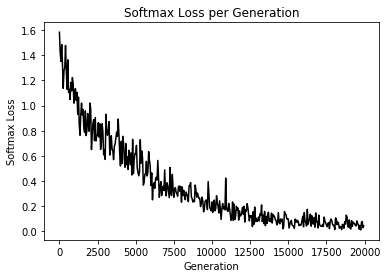

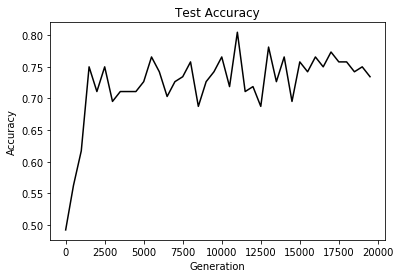

In [30]:
eval_indices = range(0, generations, eval_every)
output_indices = range(0, generations, output_every)

# 損失値のプロット
plt.plot(output_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# 正解率のプロット
plt.plot(eval_indices, test_accuracy, 'k-')
plt.title('Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
#plt.show()

In [35]:
# 学習モデルの保存
saver = tf.train.Saver()

saver.save(sess, './temp/cnn_model')

'./temp/cnn_model'

In [36]:
# 学習モデルの復元
saver.restore(sess, './temp/cnn_model')

INFO:tensorflow:Restoring parameters from ./temp/cnn_model
